# Earthquake

Create a simple Decoder for the Earthquake data.

/ HYSTORY / -----------------------------------------------------------------

2025/06/05: v0 (from Decoder_mock_v0) /

2025/06/06: v0_1 /
- Corrected: Using preprocessed data with correct sorting of rows (bottom-to-top)

/ NOTES / -------------------------------------------------------------------

# Setup

In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import os

# Current path ---------------------------------------------------------------
script_path = str(Path().absolute())
print('Current path:', script_path)
#-----------------------------------------------------------------------------

# Results folder -------------------------------------------------------------
path_results = script_path + "/results"
# folder where the current run's results shall be nested in

if not os.path.exists(path_results):
    os.makedirs(path_results)
    print('Folder "%s" created.' % os.path.basename(path_results))
#-----------------------------------------------------------------------------

# Imported data folder -------------------------------------------------------
path_data = script_path + "/data"
# folder inside which the preprocessed data will be copied

if not os.path.exists(path_data):
    os.makedirs(path_data)
    print('Folder "%s" created.' % os.path.basename(path_data))
#-----------------------------------------------------------------------------

import warnings
warnings.filterwarnings('ignore')
# keep it quiet, jeez!

Current path: /media/work/8_Alma/earthquake_CNN/Decoder


In [2]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    
    # For cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Desired device:', device)

print(torch.cuda.is_available())        # Should return True
print(torch.cuda.current_device())      # Should not raise an error
print(torch.cuda.get_device_name(0))    # Should show RTX 4090

Desired device: cuda
True
0
NVIDIA GeForce RTX 4090 Laptop GPU


# Utils

## condition_vector_to_df

In [3]:
import pandas as pd
import numpy as np
import warnings

def condition_vector_to_df(cond_vector: np.ndarray) -> pd.DataFrame:
    """
    Decode a conditioning vector into a single-row DataFrame with named columns.
    Supports formats with or without POV one-hot columns (POV_A, POV_B, POV_C).
    Issues a warning if the vector length is unexpected.
    """

    # Define expected column structures
    base_fields = ["length", "width", "height", "thickness", "r", "c", "PGA", "Hz"]
    pov_fields = ["POV_A", "POV_B", "POV_C"]

    if len(cond_vector) == len(base_fields) + len(pov_fields):  # 11
        columns = base_fields + pov_fields
    elif len(cond_vector) == len(base_fields):  # 8
        columns = base_fields
    else:
        warnings.warn(f"Unexpected conditioning vector length: {len(cond_vector)}. "
                      f"Expected 8 or 11.")
        columns = [f"param_{i}" for i in range(len(cond_vector))]

    # Format values
    data = {}
    for i, col in enumerate(columns):
        val = cond_vector[i]
        if col.startswith("POV_"):
            data[col] = int(round(val))  # always keep as int
        else:
            data[col] = float(val)       # everything else as float

    return pd.DataFrame([data])

## display_vector_and_image

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def display_vector_and_image(img_tensor, condition_vector, image_name=None):
    """
    Display decoded conditioning vector alongside the corresponding image.
    Accepts an image tensor (C, H, W) and a condition vector (numpy).
    """

    # Convert tensor to numpy image, handling both grayscale and RGB
    if img_tensor.ndim == 3 and img_tensor.shape[0] in [1, 3]:
        img = img_tensor.permute(1, 2, 0).numpy()  # C, H, W → H, W, C
        if img.shape[2] == 1:
            img = img.squeeze(-1)  # Convert (H, W, 1) to (H, W) for grayscale
    else:
        img = img_tensor.numpy()
    
    # Create base DataFrame from condition vector
    df = condition_vector_to_df(condition_vector)

    # Format originally integer columns to remove trailing .0 when printing
    int_like_cols = ["length", "width", "height", "thickness", "r", "c", "POV"]
    one_hot_cols = ["POV_A", "POV_B", "POV_C"]
    for col in int_like_cols + one_hot_cols:
        if col in df.columns:
            df[col] = df[col].apply(
                lambda x: f"{float(x):g}" if isinstance(x, (int, float)) and float(x).is_integer() else x
            )

    # Add image name as a new first column (with the same value for all columns)
    df.insert(0, "Image", [image_name] * len(df))

    # Display with left-aligned headers and no index
    styled_df = df.style.set_table_styles(
        [{"selector": "th", "props": [("text-align", "left")]}]
    ).set_properties(**{"text-align": "left"}).hide(axis="index")
    display(styled_df)

    # Show image
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.imshow(img, origin='upper', cmap='magma' if img.ndim == 2 else None)
    ax.set_xlabel("x [pixels]")
    ax.set_ylabel("y [pixels]")
    plt.show()


## visualize_sample

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd

def visualize_sample(X_i, y_i, yhat_i, idx=None, image_names=None, epoch=None):
    """
    - Print decoded info using `condition_vector_to_df`
    - Plot the real vs generated image
    - If `idx` and `image_names` are provided, shows image name in DataFrame
    """

    # Decode and display the condition info
    df = condition_vector_to_df(X_i.clone().detach().cpu().numpy())

    # Add image name if available
    if idx is not None and image_names is not None:
        image_name = image_names[idx]
        df.insert(0, "Image", [image_name] * len(df))
    else:
        image_name = None  # for consistent use below
    
    # Display DataFrame
    styled_df = df.style.set_table_styles(
        [{"selector": "th", "props": [("text-align", "left")]}]
    ).set_properties(**{"text-align": "left"}).hide(axis="index")
    display(styled_df)

    # Convert tensors to NumPy
    y_i_np    = y_i.clone().detach().cpu().numpy()
    yhat_i_np = yhat_i.clone().detach().cpu().numpy()

    # If RGB, reshape from (C, H, W) to (H, W, C)
    if y_i_np.ndim == 3 and y_i_np.shape[0] == 3:
        y_i_np    = np.transpose(y_i_np, (1, 2, 0))
        yhat_i_np = np.transpose(yhat_i_np, (1, 2, 0))
        is_rgb = True
    else:
        y_i_np    = y_i_np.squeeze()
        yhat_i_np = yhat_i_np.squeeze()
        is_rgb = False

    # Plot the images
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    if epoch is not None:
        fig.suptitle(f"Epoch {epoch}", y=0.95)

    axes[0].set_title("$y$")
    if is_rgb:
        cbar0 = axes[0].imshow(y_i_np, origin='upper')
    else:
        cbar0 = axes[0].imshow(y_i_np, cmap='magma', origin='upper', vmin=y_i_np.min(), vmax=y_i_np.max())

    axes[1].set_title("$\hat{y}$")
    if is_rgb:
        cbar1 = axes[1].imshow(yhat_i_np, origin='upper')
    else:
        cbar1 = axes[1].imshow(yhat_i_np, cmap='magma', origin='upper', vmin=y_i_np.min(), vmax=y_i_np.max())

    for ax in axes:
        ax.set_xlabel("x [pixels]")
        ax.set_ylabel("y [pixels]")

    # Overlay
    axes[2].set_title("Overlay")
    if is_rgb:
        cbar2 = axes[2].imshow(yhat_i_np, origin='upper')
        z_contour = np.mean(y_i_np, axis=2)  # simple luminance projection
    else:
        cbar2 = axes[2].imshow(yhat_i_np, cmap='magma', origin='upper', vmin=y_i_np.min(), vmax=y_i_np.max())
        z_contour = y_i_np

    axes[2].contour(z_contour, colors='white', levels=5, linewidths=0.5)

    # Add colorbars (only if grayscale)
    if not is_rgb:
        fig.colorbar(cbar0, ax=axes[0], orientation='vertical', shrink=0.35, aspect=10)
        fig.colorbar(cbar1, ax=axes[1], orientation='vertical', shrink=0.35, aspect=10)
        fig.colorbar(cbar2, ax=axes[2], orientation='vertical', shrink=0.35, aspect=10)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1)
    plt.show()


In [6]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history['epoch'], history['loss_train'], c='C0', lw=1, label='train')
    plt.plot(history['epoch'], history['loss_valid'], c='C1', lw=1, label='valid')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, None])
    plt.title('Loss History')
    plt.legend(loc='upper left', ncol=2)
    plt.gca().spines[['right', 'top']].set_visible(False)
    plt.tight_layout()
    plt.show(block=False)
    plt.pause(0.1)
    plt.close()

# Data

## Import preprocessed images

In [7]:
import os
import shutil

# Define source and destination base paths
path_preprocessed = os.path.abspath(os.path.join("..", "prepare_data", "results"))
folders_preprocessed = ["Output 1", "Output 2", "Output 3", "Output 4"]

for folder in folders_preprocessed:
# debug: for folder in ["Output 1"]:
    src_folder = os.path.join(path_preprocessed, folder)
    dst_folder = os.path.join(path_data, folder)

    # Create destination folder if it doesn't exist
    os.makedirs(dst_folder, exist_ok=True)

    for subfolder_name in os.listdir(src_folder):
    # debug: for subfolder_name in os.listdir(src_folder)[:2]:
        subfolder_path = os.path.join(src_folder, subfolder_name)
        if os.path.isdir(subfolder_path) and subfolder_name.startswith("DesignPoint") and len(subfolder_name) > len("DesignPoint"):
            # Extract letter and zero-padded number
            design_letter = subfolder_name[len("DesignPoint")]
            design_number = ''.join(filter(str.isdigit, subfolder_name))
            padded_number = design_number.zfill(4)

            prefix = f"DP_{design_letter}_{padded_number}"

            valid_files = [
                file_name for file_name in os.listdir(subfolder_path)
                if file_name.startswith("06_valid")
            ]
            
            for file_name in valid_files:
                new_file_name = file_name.replace("06_valid", "bay")
                dst_file_name = f"{prefix}_{new_file_name}"
                src_file = os.path.join(subfolder_path, file_name)
                dst_file = os.path.join(dst_folder, dst_file_name)
                shutil.copy2(src_file, dst_file)

print("Data imported.")

Data imported.


## Prepare conditioning vectors

This happens in 2 steps:
1. We re-arrange the excel file, checking that each existing image corresponds to the value in the "Design point" column
2. We create a per-bay catalogue, where we add the location of the bay within the image as extra parameter

In [8]:
import os
import shutil
import pandas as pd
import glob

# Name of the Excel file (assumed to be in the same folder as the script)
excel_filename = "Third Journal Article Parameters.xlsx"

# Absolute path for output CSV
csv_dst_path = os.path.join(path_data, "info_df.csv")

# Read Excel into DataFrame
df = pd.read_excel(excel_filename)
df_info = df.copy()

# Drop any completely empty columns
df_info.dropna(axis=1, how='all', inplace=True)

# Build a set of available DP_<number> keys based on existing images
available_dps = set()

for folder in os.listdir(path_data):
    folder_path = os.path.join(path_data, folder)
    if folder.startswith("Output 1") and os.path.isdir(folder_path): 
        # NOTE: It is enough to do this for the "Output 1" folder, since the parameters are common
        image_files = glob.glob(os.path.join(folder_path, "DP_*_*.png"))
        for image_file in image_files:
            base_name = os.path.basename(image_file)
            parts = base_name.split("_")
            if len(parts) >= 3 and parts[0] == "DP":
                dp_number = parts[2]  # e.g., "0005"
                available_dps.add(dp_number)

# Create the "DP" column based on the 'Design point' column
dp_column = []
for dp in df["Design point"]:
    padded_dp = str(int(dp)).zfill(4)
    dp_column.append(padded_dp if padded_dp in available_dps else "NA")

# Insert the "DP" column as the first column
df_info.insert(0, "DP", dp_column)

# Rename columns to user-friendly labels (mind the gaps)
df_info.rename(columns={
    "Length - No. of bays ": "length",
    "Width - No. of bays ": "width",
    "Number of Storeys": "height",
    "Plate thickness": "thickness",
    "Design point": "design_point",
}, inplace=True)

# Save the final DataFrame as a CSV
df_info.to_csv(csv_dst_path, index=False)

print(f"Created file: {csv_dst_path}")
display(df_info.head(5))

Created file: /media/work/8_Alma/earthquake_CNN/Decoder/data/info_df.csv


,DP,length,width,height,thickness,PGA,design_point,Hz
0,0002,3,4,3,10,0.2458,2,5.091223
1,0003,4,5,3,10,0.2458,3,4.298888
2,0004,5,6,3,10,0.2458,4,5.398558
3,0006,7,8,3,10,0.2458,6,4.298326
4,0007,8,9,3,10,0.2458,7,3.939938


In [9]:
import os
import re
import pandas as pd
import glob

# Ensure DP column is string for matching
df_info["DP"] = df_info["DP"].astype(str).str.zfill(4)

# Map POV letters to numbers
POV_map = {"A": 0, "B": 1, "C": 2, "D": 3}

all_folders_dfs = []  # list to hold all folder-level DataFrames

# Loop over Output folders and their image files
folder_names = sorted([
    f for f in os.listdir(path_data)
    if os.path.isdir(os.path.join(path_data, f)) and f.startswith("Output ")
])

for folder_name in folder_names:
    print('[===== Folder: %s =====]' % folder_name)
    
    # Prepare rows for the folder's dataframe
    rows_folder = []

    folder_path = os.path.join(path_data, folder_name)
    
    # List of images inside each Output folder
    image_names = [
        filename for filename in os.listdir(folder_path)
        if filename.endswith(".png") and filename.startswith("DP_")
    ]
    
    for i, image_name in enumerate(image_names):
        print('Image %-5s[/%-5s]' % (i+1, len(image_names)), end='\r')

        # Parse the filename
        match = re.match(r"DP_([A-D])_(\d{4})_bay_R\d+_C\d+_r(\d+)_c(\d+)\.png", image_name)
        if match:
            POV_file, DP_file, r, c = match.groups()
        else:
            print('ERROR: Image filename %s not parsed!' % image_name)
            continue
        
        # Try to find the row in df_info which matches the image filename
        row_info = df_info[df_info["DP"] == DP_file]
        
        if row_info.empty:
            print('ERROR: Image %s has no correspondance in info_df!' % image_name)
            continue
        else:
            info = row_info.iloc[0]
            rows_folder.append({
                "Image": image_name,
                "DP": info["DP"],
                "length": info["length"],
                "width": info["width"],
                "height": info["height"],
                "thickness": info["thickness"],
                "POV": POV_map[POV_file],
                "r": int(r),
                "c": int(c),
                "PGA": info["PGA"],
                "design_point": info["design_point"],
                "Hz": info["Hz"]
            })

    # Create dataframe for this folder
    df_conditioning_vectors_folder = pd.DataFrame(rows_folder)

    # Encode POV column into POV_A, POV_B, POV_C — D (3) becomes all zeros
    if "POV" in df_conditioning_vectors_folder.columns:
        dummies = pd.get_dummies(df_conditioning_vectors_folder["POV"])
        dummies = dummies.reindex(columns=[0, 1, 2], fill_value=0).rename(
            columns={0: "POV_A", 1: "POV_B", 2: "POV_C"}
        ).astype("int8")  # Ensure 1/0 as int, not bool
        df_conditioning_vectors_folder = pd.concat([df_conditioning_vectors_folder, dummies], axis=1)
        df_conditioning_vectors_folder.drop(columns=["POV"], inplace=True)


    # Sort by DP, then drop all the other DP-related columns (POV is now one-hot encoded)
    df_conditioning_vectors_folder.sort_values(by="DP", inplace=True)
    df_conditioning_vectors_folder.drop(columns=["DP", "design_point"], inplace=True)
    
    display(df_conditioning_vectors_folder.head(5))

    output_csv = os.path.join(path_data, f"conditioning_vectors_{POV_file}_df.csv")
    df_conditioning_vectors_folder.to_csv(output_csv, index=False)

    # Append to list containing all DataFrames
    all_folders_dfs.append(df_conditioning_vectors_folder)

# Create final dataframe
df_conditioning_vectors = pd.concat(all_folders_dfs, ignore_index=True)
print('Complete DataFrame:')
display(df_conditioning_vectors.head(5))

# Save to CSV in path_data
output_csv = os.path.join(path_data, "conditioning_vectors_df.csv")
df_conditioning_vectors.to_csv(output_csv, index=False)

print(f"df_conditioning_vectors.csv written to: {output_csv}")

[===== Folder: Output 1 =====]
Image 34753[/34753]

,Image,length,width,height,thickness,r,c,PGA,Hz,POV_A,POV_B,POV_C
8909,DP_A_0002_bay_R3_C4_r1_c2.png,3,4,3,10,1,2,0.2458,5.091223,1,0,0
23658,DP_A_0002_bay_R3_C4_r0_c2.png,3,4,3,10,0,2,0.2458,5.091223,1,0,0
31363,DP_A_0002_bay_R3_C4_r2_c2.png,3,4,3,10,2,2,0.2458,5.091223,1,0,0
6391,DP_A_0003_bay_R3_C5_r1_c2.png,4,5,3,10,1,2,0.2458,4.298888,1,0,0
7187,DP_A_0003_bay_R3_C5_r0_c2.png,4,5,3,10,0,2,0.2458,4.298888,1,0,0


[===== Folder: Output 2 =====]
Image 34757[/34757]

,Image,length,width,height,thickness,r,c,PGA,Hz,POV_A,POV_B,POV_C
16776,DP_B_0002_bay_R3_C4_r1_c1.png,3,4,3,10,1,1,0.2458,5.091223,0,1,0
26915,DP_B_0002_bay_R3_C4_r2_c1.png,3,4,3,10,2,1,0.2458,5.091223,0,1,0
16947,DP_B_0002_bay_R3_C4_r0_c1.png,3,4,3,10,0,1,0.2458,5.091223,0,1,0
6152,DP_B_0003_bay_R3_C5_r2_c2.png,4,5,3,10,2,2,0.2458,4.298888,0,1,0
7941,DP_B_0003_bay_R3_C5_r1_c2.png,4,5,3,10,1,2,0.2458,4.298888,0,1,0


[===== Folder: Output 3 =====]
Image 34748[/34748]

,Image,length,width,height,thickness,r,c,PGA,Hz,POV_A,POV_B,POV_C
1159,DP_C_0002_bay_R3_C4_r2_c1.png,3,4,3,10,2,1,0.2458,5.091223,0,0,1
17851,DP_C_0002_bay_R3_C4_r0_c1.png,3,4,3,10,0,1,0.2458,5.091223,0,0,1
10182,DP_C_0002_bay_R3_C4_r1_c1.png,3,4,3,10,1,1,0.2458,5.091223,0,0,1
20437,DP_C_0003_bay_R3_C5_r2_c2.png,4,5,3,10,2,2,0.2458,4.298888,0,0,1
1004,DP_C_0003_bay_R3_C5_r1_c2.png,4,5,3,10,1,2,0.2458,4.298888,0,0,1


[===== Folder: Output 4 =====]
Image 35029[/35029]

,Image,length,width,height,thickness,r,c,PGA,Hz,POV_A,POV_B,POV_C
28550,DP_D_0002_bay_R3_C4_r1_c2.png,3,4,3,10,1,2,0.2458,5.091223,0,0,0
15730,DP_D_0002_bay_R3_C4_r0_c2.png,3,4,3,10,0,2,0.2458,5.091223,0,0,0
22817,DP_D_0002_bay_R3_C4_r2_c2.png,3,4,3,10,2,2,0.2458,5.091223,0,0,0
17799,DP_D_0003_bay_R3_C5_r1_c2.png,4,5,3,10,1,2,0.2458,4.298888,0,0,0
31463,DP_D_0003_bay_R3_C5_r2_c2.png,4,5,3,10,2,2,0.2458,4.298888,0,0,0


Complete DataFrame:


,Image,length,width,height,thickness,r,c,PGA,Hz,POV_A,POV_B,POV_C
0,DP_A_0002_bay_R3_C4_r1_c2.png,3,4,3,10,1,2,0.2458,5.091223,1,0,0
1,DP_A_0002_bay_R3_C4_r0_c2.png,3,4,3,10,0,2,0.2458,5.091223,1,0,0
2,DP_A_0002_bay_R3_C4_r2_c2.png,3,4,3,10,2,2,0.2458,5.091223,1,0,0
3,DP_A_0003_bay_R3_C5_r1_c2.png,4,5,3,10,1,2,0.2458,4.298888,1,0,0
4,DP_A_0003_bay_R3_C5_r0_c2.png,4,5,3,10,0,2,0.2458,4.298888,1,0,0


df_conditioning_vectors.csv written to: /media/work/8_Alma/earthquake_CNN/Decoder/data/conditioning_vectors_df.csv


# Dataloader

In [10]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from prettytable import PrettyTable

from typing import Literal, Optional

class ImageDataset(Dataset):
    """
    A PyTorch Dataset for loading images and their associated conditioning vectors.

    This dataset:
    - Loads conditioning data from a CSV file.
    - Optionally scales the conditioning vectors using a StandardScaler.
    - Loads and transforms corresponding images from disk.

    Attributes:
        path_data (str): Root path containing image folders and conditioning CSV file.
        cond (np.ndarray): Unnormalized conditioning vectors.
        cond_n (np.ndarray): Normalized conditioning vectors (if scaling is applied).
        image_names (List[str]): List of image file names.
        image_paths (List[str]): Full paths to each image file.
        scaler (StandardScaler or None): The fitted scaler (if used).
        transform (torchvision.transforms): Transform applied to each image.
    Args:
        path_data (str): Root directory with image folders and conditioning file.
        conditioning_file (str): CSV filename with "Image" column and conditioning variables.
        scaler (StandardScaler, optional): Existing scaler to use when scale_mode="use".
        scale_mode (Literal["fit", "use", "none"], default="none"):
            - "fit": Fit a new scaler to the conditioning vectors.
            - "use": Use the provided `scaler` to transform the data.
            - "none": Use raw conditioning vectors with no scaling.

    Returns:
        cond_n (Tensor): Normalized conditioning vector.
        image (Tensor): Transformed image tensor [3 x 64 x 64].
        cond (Tensor): Raw conditioning vector.
        idx (int): Index of the sample.
    """    
    def __init__(
        self,
        path_data,
        conditioning_file,
        scaler: Optional[StandardScaler] = None,
        scale_mode: Literal["fit", "use", "none"] = "none"
    ):
        self.path_data = path_data

        # Load condition DataFrame
        df_cond = pd.read_csv(os.path.join(self.path_data, conditioning_file), index_col=False)
        self.image_names = df_cond["Image"].tolist()

        # 🔧 Drop Image column since it is not a conditioning variable
        df_cond = df_cond.drop(columns=["Image"])
        
        # 🔧 Drop POV columns that are constant (e.g., POV_A, POV_B, POV_C)
        pov_cols = [col for col in df_cond.columns if col.startswith("POV_")]
        for col in pov_cols:
            if df_cond[col].nunique() == 1:
                print(f"WARNING: Dropping constant POV column: {col}")
                df_cond.drop(columns=[col], inplace=True)
        
        # Separate POV columns (do not normalize) and numeric columns (to normalize)
        pov_cols = [col for col in df_cond.columns if col.startswith("POV_")]
        num_cols = [col for col in df_cond.columns if col not in pov_cols]

        df_num = df_cond[num_cols]
        df_pov = df_cond[pov_cols]
        
        # 🔧 Apply scaling only to numerical part
        if scale_mode == "fit":
            self.scaler = MinMaxScaler().fit(df_num.values)
            cond_n_num = self.scaler.transform(df_num.values)
        elif scale_mode == "use" and scaler is not None:
            self.scaler = scaler
            cond_n_num = self.scaler.transform(df_num.values)
        elif scale_mode == "none":
            self.scaler = None
            cond_n_num = df_num.values
        else:
            raise ValueError("Invalid scaler setup. Use 'fit', 'use', or 'none'.")
        
        # 🔧 Combine scaled numeric and raw POV parts
        cond_pov = df_pov.values
        self.cond_n = np.hstack([cond_n_num, cond_pov]).astype(np.float32)
        
        # 🔧 Also save the raw (unnormalized) version
        self.cond = pd.concat([df_num, df_pov], axis=1).astype(np.float32).values

        # 🔧 Resize to fixed shape here
        self.transform = transforms.Compose([
            transforms.Resize((64, 64)),   
            transforms.ToTensor()  # <--- Normalizes images to [0..1]
        ])

        # Map prefix letter to Output folder
        self.prefix_map = {"A": "Output 1", "B": "Output 2", "C": "Output 3", "D": "Output 4"}

        # 🔧 Build list of full image paths
        self.image_paths = []
        for name in self.image_names:
            prefix_letter = name.split("_")[1]
            folder_name = self.prefix_map.get(prefix_letter)
            if folder_name is None:
                raise ValueError(f"Unknown prefix '{prefix_letter}' in image name '{name}'")
            image_path = os.path.join(self.path_data, folder_name, name)
            if not os.path.exists(image_path):
                raise FileNotFoundError(f"Missing image file: {image_path}")
            self.image_paths.append(image_path)

    def __len__(self):
        return len(self.cond)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image = self.transform(image) if self.transform else transforms.ToTensor()(image)
        # print(f"[DEBUG] Image shape: {image.shape}")

        cond_n = torch.tensor(self.cond_n[idx], dtype=torch.float32)
        cond = torch.tensor(self.cond[idx], dtype=torch.float32)

        return cond_n, image, cond, idx  # Return idx too

# Parameters
batch_size = 256

# Step 1: Create full dataset (with normalization fitted)
dataset = ImageDataset(
    path_data=path_data,
    conditioning_file="conditioning_vectors_df.csv",
    scale_mode="fit",
)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Step 2: Split dataset
total_len = len(dataset)
train_len = int(0.8 * total_len)
valid_len = int(0.1 * total_len)
test_len = total_len - train_len - valid_len

# Use a fixed seed for reproducibility
generator = torch.Generator().manual_seed(42)

# Split
dataset_train, dataset_valid, dataset_test = random_split(\
    dataset, [train_len, valid_len, test_len], generator=generator,
)

# Step 3: Create separate DataLoaders
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, generator=generator, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, generator=generator, shuffle=False)  # To see the same valid plots
dataloader_test  = DataLoader(dataset_test,  batch_size=test_len,   generator=generator, shuffle=False)  # Test needs only 1 batch

# Test batch shapes
X_train_n_batch, y_train_batch, X_train_batch, idxs_train = next(iter(dataloader_train))
X_valid_n_batch, y_valid_batch, X_valid_batch, idxs_valid = next(iter(dataloader_valid))
X_test_n_batch,  y_test_batch,  X_test_batch,  idxs_test  = next(iter(dataloader_test))

table = PrettyTable()
table.field_names = ["Split", "X_n shape", "y shape", "X shape"]
table.add_row(["Train", list(X_train_n_batch.shape), list(y_train_batch.shape), list(X_train_batch.shape)])
table.add_row(["Valid", list(X_valid_n_batch.shape), list(y_valid_batch.shape), list(X_valid_batch.shape)])
table.add_row(["Test",  list(X_test_n_batch.shape),  list(y_test_batch.shape),  list(X_test_batch.shape)])
print(table)

+-------+-------------+--------------------+-------------+
| Split |  X_n shape  |      y shape       |   X shape   |
+-------+-------------+--------------------+-------------+
| Train |  [256, 11]  |  [256, 3, 64, 64]  |  [256, 11]  |
| Valid |  [256, 11]  |  [256, 3, 64, 64]  |  [256, 11]  |
|  Test | [13930, 11] | [13930, 3, 64, 64] | [13930, 11] |
+-------+-------------+--------------------+-------------+


## Check dataloader

Image,length,width,height,thickness,r,c,PGA,Hz,POV_A,POV_B,POV_C
DP_A_2570_bay_R3_C8_r1_c3.png,4,8,3,10,1,3,0.380000,4.744205,1,0,0


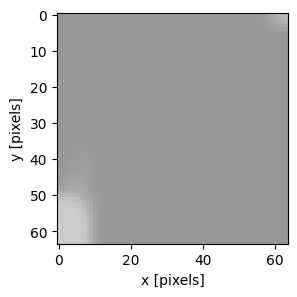

Image,length,width,height,thickness,r,c,PGA,Hz,POV_A,POV_B,POV_C
DP_A_2607_bay_R5_C3_r1_c1.png,9,3,5,10,1,1,0.380000,2.178291,1,0,0


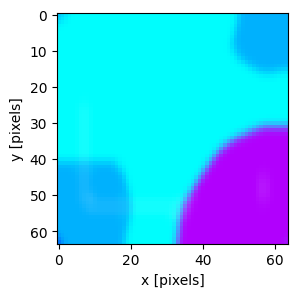

Image,length,width,height,thickness,r,c,PGA,Hz,POV_A,POV_B,POV_C
DP_D_2339_bay_R5_C6_r3_c3.png,5,6,5,25,3,3,0.146000,3.838762,0,0,0


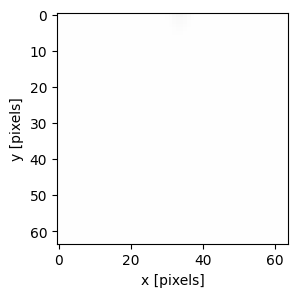

In [11]:
# Pick 3 samples from a dataloader and display them
for i in range(3):
    cond_vec = X_train_batch[i].numpy()
    sample_idx = idxs_train[i].item()  # idxs_train is a tensor, convert to int
    image_name = dataset.image_names[sample_idx]

    display_vector_and_image(y_train_batch[i], cond_vec, image_name=image_name)

Image,length,width,height,thickness,r,c,PGA,Hz,POV_A,POV_B,POV_C
DP_A_0002_bay_R3_C4_r1_c2.png,0.142857,0.142857,0.000000,0.000000,0.111111,0.222222,0.426496,0.558362,1,0,0


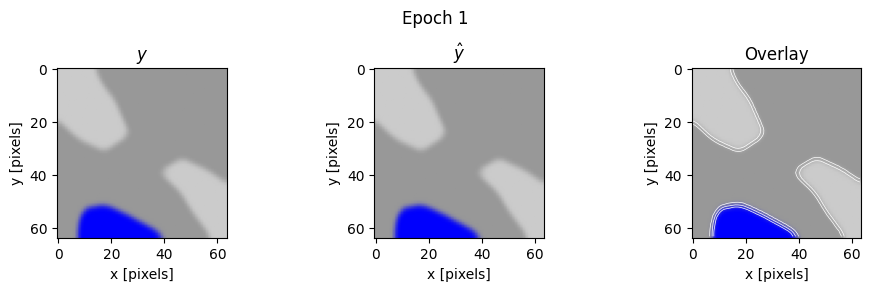

In [12]:
"""Testing visualize_sample""";
# Get one sample from the dataset
cond_n, image_tensor, cond_raw, idx = dataset[0]

# Visualize
visualize_sample(X_i=cond_n, y_i=image_tensor, yhat_i=image_tensor,
    idx=idx, image_names=dataset.image_names, epoch=1)

# Decoder

## Architecture

In [13]:
import torch
import torch.nn as nn
from torchinfo import summary
from torchview import draw_graph

class Decoder(nn.Module):
    def __init__(
        self,
        cond_dim=21,
        img_width=64,
        img_height=64,
        init_channels=64,          # number of filters for the first layer
        conv_channels=(32, 16, 8), # output channels for each upsampling layer
        out_channels=3             # output image channels (e.g., 3 for RGB)
    ):
        super().__init__()

        # === Dimensions & configuration ===
        self.input_dim = cond_dim           # input to the FC projection block
        self.init_channels = init_channels  # initial feature map depth
        self.conv_channels = conv_channels  # tuple of output channels for conv blocks
        self.out_channels = out_channels    # final image channels

        # === Normalize condition ===
        self.cond_norm = nn.BatchNorm1d(cond_dim, affine=True)  # normalize conditions (params learnt)

        # === Initial feature map size ===
        self.n_upsamples = len(conv_channels)  # determines how much to upscale
        self.init_width  = img_width  // (2 ** self.n_upsamples)
        self.init_height = img_height // (2 ** self.n_upsamples)
        fc_output_dim = self.init_channels * self.init_height * self.init_width

        # === Fully connected layers to go from latent to feature map ===
        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 512),
            # nn.BatchNorm1d(512),
            nn.ReLU(True),

            nn.Linear(512, fc_output_dim),
            # nn.BatchNorm1d(fc_output_dim),
            nn.ReLU(True)
        )

        # === Transposed convolutional blocks for upsampling ===
        conv_layers = []
        in_ch = self.init_channels
        for out_ch in conv_channels:
            conv_layers += [
                nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1),
                # nn.BatchNorm2d(out_ch),
                nn.ReLU(True)
            ]
            in_ch = out_ch  # update for next block

        # Final output layer to desired number of channels (e.g., RGB)
        conv_layers += [
            nn.Conv2d(in_ch, self.out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()    # <--- Normalizes images to [0..1], compatibly to DataLoade
        ]
        self.conv_blocks = nn.Sequential(*conv_layers)

    def forward(self, cond):
        # Normalize the condition vector
        cond_n = self.cond_norm(cond)  # shape: (B, cond_dim)

        # Project to a flattened feature map
        x = self.fc(cond_n)  # shape: (B, init_channels * H * W)

        # Reshape to image format
        x = x.view(x.size(0), self.init_channels, self.init_height, self.init_width)  # shape: (B, C, H, W)

        # Upsample to full-resolution image
        x = self.conv_blocks(x)  # shape: (B, out_channels, img_height, img_width)

        return x

# Example usage
cond_dim = X_train_batch.shape[1]
height, width = y_train_batch.shape[2], y_train_batch.shape[3]
out_channels = y_train_batch.shape[1]

D = Decoder(
    cond_dim=cond_dim,
    img_width=width,
    img_height=height,
    init_channels=128,
    conv_channels=(64, 32, 16),
    out_channels=out_channels
).to(device)

X_train_sample = X_train_batch[:4].to(device)

yhat_sample = D(X_train_sample)
print(yhat_sample.shape)  # torch.Size([4, 3, height, width])

# Summary
display(summary(D, input_data=(X_train_sample,)))

# Graph (to file)
model_graph = draw_graph(D, input_data=(X_train_sample,),
    graph_dir="LR", expand_nested=True, show_shapes=True, save_graph=True, filename="arch_decoder"
)
model_graph.visual_graph.graph_attr["dpi"] = "600"
model_graph.visual_graph.render(filename=os.path.join(path_results,"arch_decoder"), format="png", cleanup=True);


torch.Size([4, 3, 64, 64])


Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [4, 3, 64, 64]            --
├─BatchNorm1d: 1-1                       [4, 11]                   22
├─Sequential: 1-2                        [4, 8192]                 --
│    └─Linear: 2-1                       [4, 512]                  6,144
│    └─ReLU: 2-2                         [4, 512]                  --
│    └─Linear: 2-3                       [4, 8192]                 4,202,496
│    └─ReLU: 2-4                         [4, 8192]                 --
├─Sequential: 1-3                        [4, 3, 64, 64]            --
│    └─ConvTranspose2d: 2-5              [4, 64, 16, 16]           131,136
│    └─ReLU: 2-6                         [4, 64, 16, 16]           --
│    └─ConvTranspose2d: 2-7              [4, 32, 32, 32]           32,800
│    └─ReLU: 2-8                         [4, 32, 32, 32]           --
│    └─ConvTranspose2d: 2-9              [4, 16, 64, 64]          

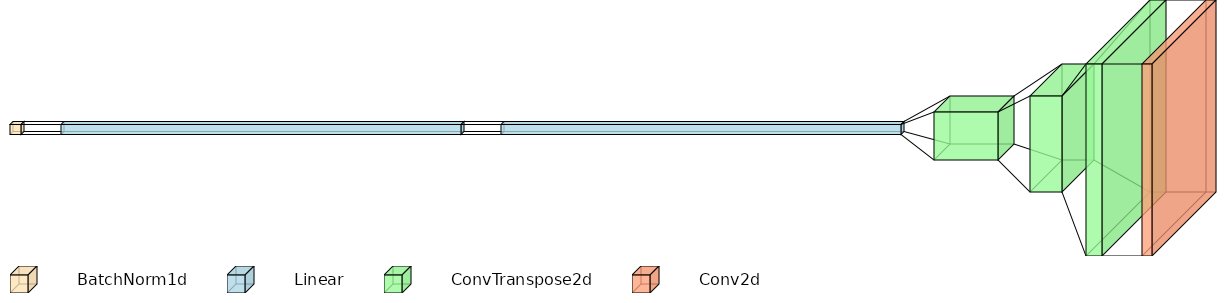

In [14]:
from PIL import ImageFont, Image
from IPython.display import display, HTML
from visualtorch import layered_view

D_plot = D.cpu()

ignored_layers = [nn.ReLU, nn.Sigmoid]
font = ImageFont.truetype("DejaVuSans.ttf", size=16)

img = layered_view(
    D_plot,
    input_shape=(2, cond_dim),
    spacing=40,
    # one_dim_orientation="x",
    scale_xy=3,
    scale_z=1,
    type_ignore=ignored_layers,
    font=font,
    legend=True,
    opacity=200,
    # padding=400
)

plt.axis("off")
plt.tight_layout()
img.save(os.path.join(path_results, "graph_decoder.png"), dpi=(300, 300))
plt.close()

# Reload and display
img_loaded = Image.open(os.path.join(path_results, "graph_decoder.png"))
display(img_loaded)

## Training

In [ ]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

n_epochs = 1000
lr = 5e-3

# Instantiate models
cond_dim = dataset[0][0].shape[0]

# Sample batch to get dimensions
X_train_n_batch, y_train_batch, X_train_batch, idxs_train = next(iter(dataloader_train))
height, width = y_train_batch.shape[2], y_train_batch.shape[3]
out_channels = y_train_batch.shape[1]

D = Decoder(
    cond_dim=X_train_batch.shape[1],
    img_width=width,
    img_height=height,
    init_channels=128,
    conv_channels=(64, 32, 16),
    out_channels=out_channels
).to(device)

# Optimizers
optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss function
criterion = nn.MSELoss()

# For tracking history
history = {
    'epoch': [],
    'loss_train': [],
    'loss_valid': [],
}

# Track best validation loss
best_loss_valid = float('inf')
path_to_best_model = path_results + "/best_decoder_model.pth"

# Training loop
for epoch in range(n_epochs):

    # === Train set ===
    D.train()
    loss_train_epoch = 0

    for i, train_batch in enumerate(tqdm(dataloader_train, desc=f"Epoch {epoch+1}/{n_epochs}")):

        X_train_batch = train_batch[0].to(device)
        y_train_batch = train_batch[1].to(device)
        # Entries:
        #   0: normalized cond, 1: image, 2: cond, 3: indexes

        D.zero_grad()

        yhat_train_batch = D(X_train_batch)
        loss_train = criterion(yhat_train_batch, y_train_batch)

        loss_train.backward()
        optimizer.step()

        loss_train_epoch += loss_train.item()

    # === Valid set ===
    D.eval()
    loss_valid_epoch = 0

    with torch.no_grad():
        for valid_batch in dataloader_valid:
            X_valid_batch = valid_batch[0].to(device)
            y_valid_batch = valid_batch[1].to(device)
            idxs_valid_batch = valid_batch[3].to(device)

            yhat_valid_batch = D(X_valid_batch)
            loss_valid = criterion(yhat_valid_batch, y_valid_batch)

            loss_valid_epoch += loss_valid.item()

    # Average losses per epoch
    avg_loss_train = loss_train_epoch / len(dataloader_train)
    avg_loss_valid = loss_valid_epoch / len(dataloader_valid)

    print(f"[===== Epoch [{epoch+1}/{n_epochs}] =====]")
    print(f"  loss - train: {loss_train_epoch:-10.4f} | avg: {avg_loss_train:.4f}")
    print(f"  loss - valid: {loss_valid_epoch:-10.4f} | avg: {avg_loss_valid:.4f}")

    # Save best model
    if avg_loss_valid < best_loss_valid:
        best_loss_valid = avg_loss_valid
        torch.save(D.state_dict(), path_to_best_model)
        print(f"[INFO] New best model saved at epoch {epoch+1} with validation loss {best_loss_valid:.4f}")
    
    # Save to history
    history['epoch'].append(epoch + 1)
    history['loss_train'].append(avg_loss_train)
    history['loss_valid'].append(avg_loss_valid)

    # Visualize the first few samples from last batch
    for idx in range(4):
        idx_dataset = idxs_valid_batch[idx].item()  # switching reference of index: batch --> dataset
        visualize_sample(X_valid_batch[idx], y_valid_batch[idx], yhat_valid_batch[idx],
                         idx=idx_dataset, image_names=dataset.image_names, epoch=epoch)
    
    # Plot history at every epoch
    plot_history(history)

## Results on Test

Average Test Loss: 0.0174


length,width,height,thickness,r,c,PGA,Hz,POV_A,POV_B,POV_C
0.714286,0.285714,0.857143,0.750000,0.777778,0.333333,0.000000,0.025555,0,0,0


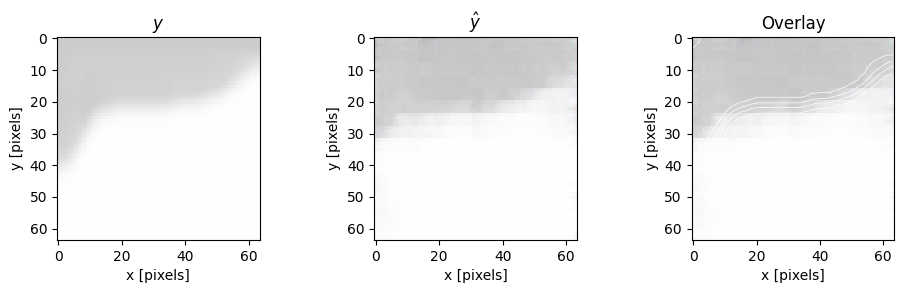

length,width,height,thickness,r,c,PGA,Hz,POV_A,POV_B,POV_C
1.000000,1.000000,0.428571,1.000000,0.000000,0.444444,0.094017,0.161907,0,0,0


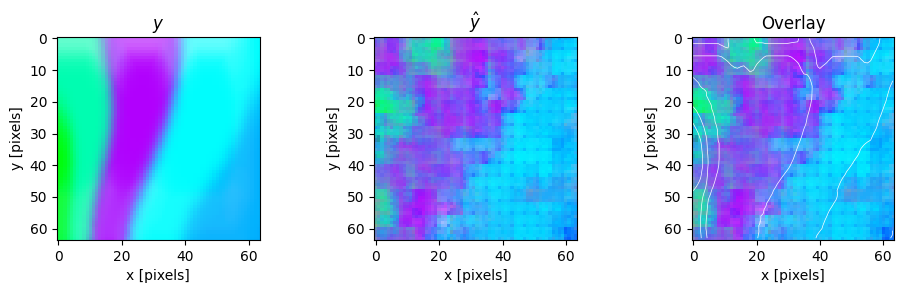

length,width,height,thickness,r,c,PGA,Hz,POV_A,POV_B,POV_C
0.285714,0.285714,0.571429,0.250000,0.111111,0.222222,1.000000,0.097380,1,0,0


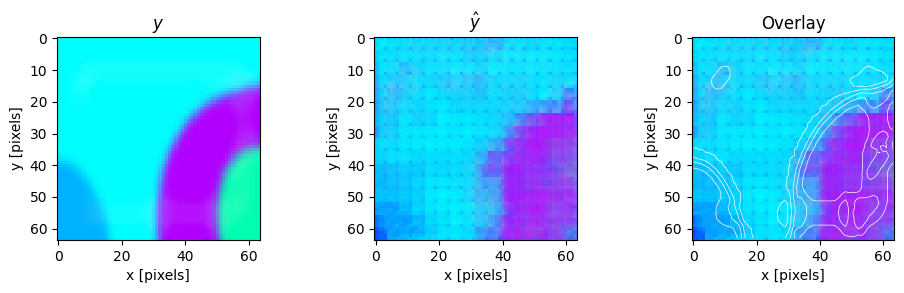

length,width,height,thickness,r,c,PGA,Hz,POV_A,POV_B,POV_C
0.571429,0.428571,0.285714,1.000000,0.111111,0.333333,0.000000,0.380792,0,1,0


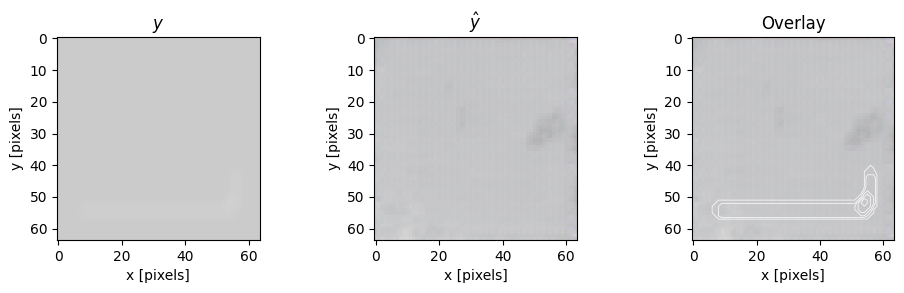

length,width,height,thickness,r,c,PGA,Hz,POV_A,POV_B,POV_C
1.000000,1.000000,1.000000,0.750000,0.222222,0.555556,0.000000,0.020000,0,1,0


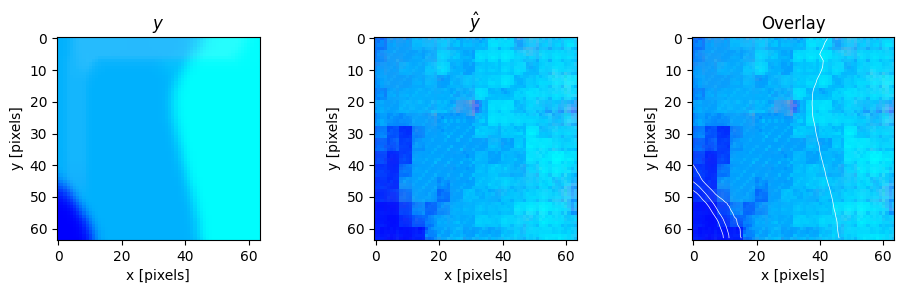

length,width,height,thickness,r,c,PGA,Hz,POV_A,POV_B,POV_C
0.714286,0.714286,0.000000,0.500000,0.000000,0.333333,0.000000,0.573600,0,1,0


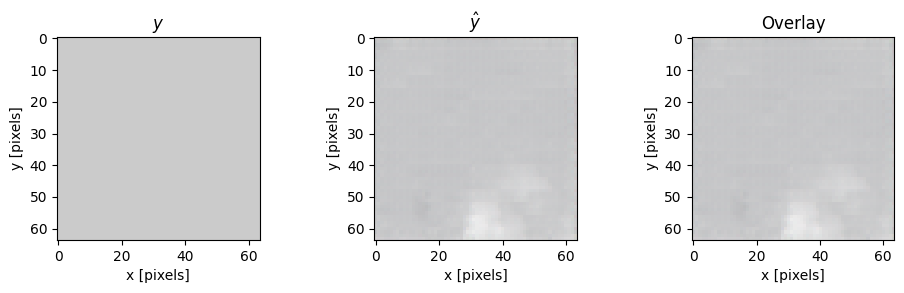

length,width,height,thickness,r,c,PGA,Hz,POV_A,POV_B,POV_C
0.857143,0.857143,0.857143,1.000000,0.777778,0.555556,0.000000,0.056203,0,1,0


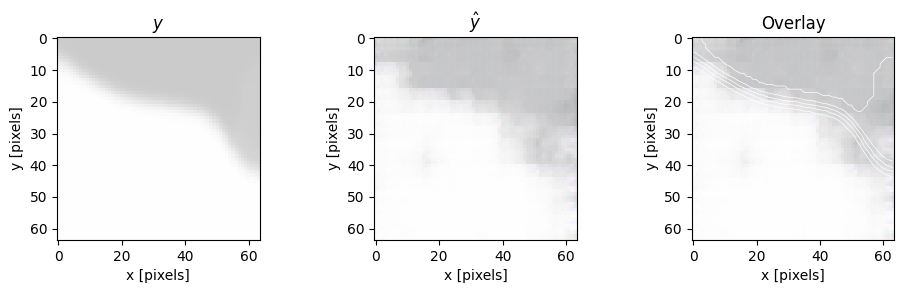

length,width,height,thickness,r,c,PGA,Hz,POV_A,POV_B,POV_C
1.000000,1.000000,1.000000,0.750000,0.333333,0.555556,0.700855,0.020000,0,0,0


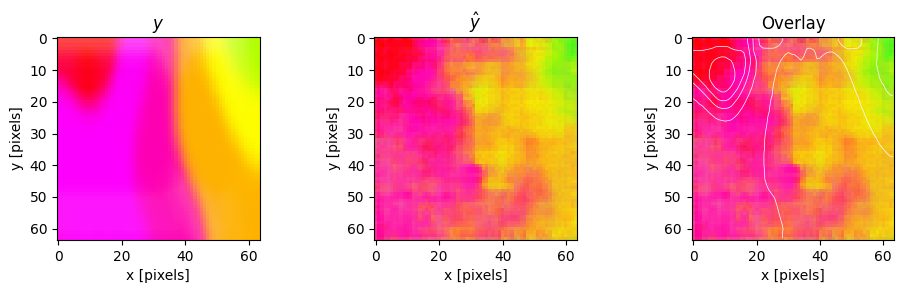

length,width,height,thickness,r,c,PGA,Hz,POV_A,POV_B,POV_C
0.857143,0.142857,0.571429,1.000000,0.333333,0.444444,1.000000,0.087445,0,0,1


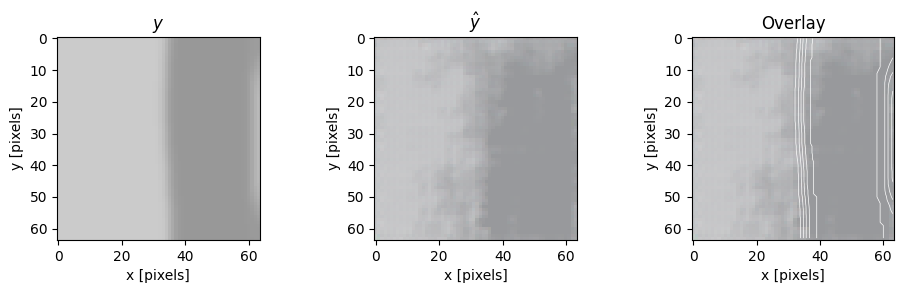

length,width,height,thickness,r,c,PGA,Hz,POV_A,POV_B,POV_C
0.714286,0.285714,0.857143,1.000000,0.888889,0.333333,0.615385,0.027801,0,0,1


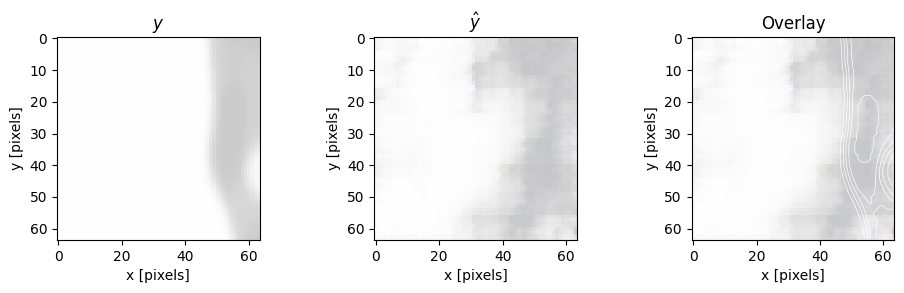

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

path_to_best_model = os.path.join(path_results, "best_decoder_model.pth")

D.load_state_dict(torch.load(path_to_best_model))
D.to(device)
D.eval()

test_loss_total = 0
criterion = nn.MSELoss()

with torch.no_grad():
    for test_batch in dataloader_test:
        X_test_batch = test_batch[0].to(device)
        y_test_batch = test_batch[1].to(device)

        yhat_test_batch = D(X_test_batch)

        loss_test_batch = criterion(yhat_test_batch, y_test_batch)
        test_loss_total += loss_test_batch.item()

    avg_test_loss = test_loss_total / len(dataloader_test)
    print(f"Average Test Loss: {avg_test_loss:.4f}")

    # Visualize the first 10 samples from the last test batch
    for idx in range(min(10, X_test_batch.shape[0])):
        visualize_sample(X_test_batch[idx], y_test_batch[idx], yhat_test_batch[idx])


In [ ]:
#EOF

In [ ]:
#EOF

In [ ]:
#EOF